In [1]:
from pathlib import Path
import time
import torch
import numpy as np
from dataset import LinearDynamicalDataset
from torch.utils.data import DataLoader
from model_ts import GPTConfig, GPT
import tqdm
import argparse
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

In [2]:
# Overall settings
out_dir = "out"

# System settings
nx = 10
nu = 1
ny = 1
seq_len = 500

# Transformer settings
block_size = seq_len
n_layer = 8
n_head = 4
n_embd = 128
dropout = 0.0
bias = False

# Optimization settings
batch_size = 256

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 5
compile = True

# Create out dir
out_dir = Path(out_dir)

# Configure compute
torch.set_num_threads(threads)
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

# Create data loader
test_ds = LinearDynamicalDataset(nx=nx, nu=nu, ny=ny, seq_len=seq_len)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=threads)

model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, n_y=1, n_u=1, block_size=block_size,
                  bias=bias, dropout=dropout)  # start with model_args from command line
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)

exp_data = torch.load(out_dir/"ckpt.pt")
state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model = model.to(device)

number of parameters: 1.64M


GPT(
  (transformer): ModuleDict(
    (wte): Linear(in_features=2, out_features=128, bias=True)
    (wpe): Embedding(500, 128)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-7): 8 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=False)
          (c_proj): Linear(in_features=128, out_features=128, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=False)
          (c_proj): Linear(in_features=512, out_features=128, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=1, bias=False)
)

In [3]:
batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)

In [4]:
# Call model like in training (future inputs/outputs known)
with torch.no_grad():
    batch_y_pred, _ = model(batch_u, batch_y, compute_loss=True)

In [5]:
# Call model causally to see if it really behaves correctly
batch_y_pred_rt = []
seq_len = batch_y.shape[1]
with torch.no_grad():
    for idx in range(seq_len):
        batch_y_t, _ = model(batch_u[:, :idx+1, :], batch_y[:, :idx+1, :], compute_loss=False)
        batch_y_pred_rt.append(batch_y_t)
batch_y_pred_rt = torch.cat(batch_y_pred_rt, dim=1)
#batch_y_pred_rt.shape

In [6]:
#torch.testing.assert_close(batch_y_pred, batch_y_pred_rt)
torch.max(torch.abs(batch_y_pred - batch_y_pred_rt))

tensor(0.0191, device='cuda:0')

In [7]:
# Call model in simulation from a certain time step!
sim_start = 50
batch_y_sim = torch.zeros_like(batch_y)
batch_y_sim[:, :sim_start, :] = batch_y[:, :sim_start, :]
with torch.no_grad():
    for idx in range(sim_start, seq_len):
        batch_y_t, _ = model(batch_u[:, :idx, :], batch_y_sim[:, :idx, :], compute_loss=False)
        batch_y_sim[:, [idx], :] = batch_y_t

In [9]:
batch_y_pred = batch_y_pred.to("cpu").detach().numpy()
batch_y_pred_rt = batch_y_pred_rt.to("cpu").detach().numpy()
batch_y_sim = batch_y_sim.detach().to("cpu").numpy()
batch_y = batch_y.detach().to("cpu").numpy()

In [10]:
batch_y_target = batch_y[:, 1:, :] # target @ time k: y_{k+1}
batch_y_pred = batch_y_pred[:, :-1, :] # prediction @ time k: y_{k+1|k}
batch_y_sim = batch_y_sim[:, 1:, :] # simulation @ time k: y_{k+1|k}
batch_pred_err = batch_y_target - batch_y_pred
batch_sim_err = batch_y_target - batch_y_pred

In [20]:
instance = 30
fig = go.Figure()
fig.add_trace(go.Scatter(y=batch_y_target[instance].squeeze(), name="y", line_color="black"))
fig.add_trace(go.Scatter(y=batch_y_sim[instance].squeeze(), name="y_sim", line_color="blue"))
#fig.add_trace(go.Scatter(y=batch_y_pred[instance].squeeze(), name="y_pred", line_color="magenta"))
fig.add_vline(x=sim_start, line_color="red", name="sim_start")
#import matplotlib.pyplot as plt
#plt.plot(batch_y[1], 'k', label="True")
#plt.plot(batch_y_pred[0], 'b', label="Pred")
#plt.plot(batch_y_pred_rt[0], 'm', label="Pred")
#plt.plot(batch_y_sim[1], 'b', label="Sim")

In [12]:
from torchid import metrics
skip = sim_start
rmse_pred = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred[:, skip:, :], time_axis=1)
rmse_sim = metrics.rmse(batch_y_target[:, skip:, :], batch_y_sim[:, skip:, :], time_axis=1)
#rmse_z = metrics.rmse(batch_y_target[:, skip:, :], 0*batch_y_sim[:, skip:, :], time_axis=1)

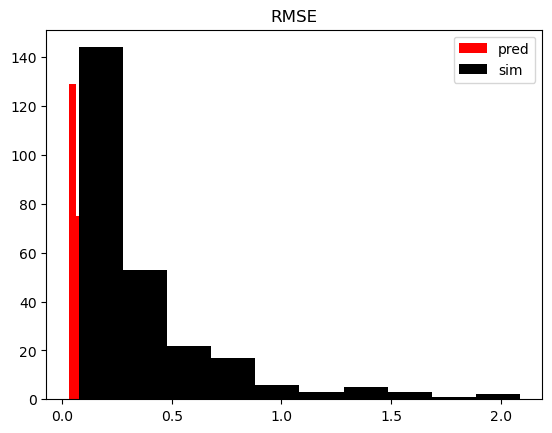

In [14]:
plt.figure()
plt.title("RMSE")
plt.hist(rmse_pred, color="red", label="pred");
plt.hist(rmse_sim, color="black", label="sim");
plt.legend();